<a href="https://colab.research.google.com/github/DerrianHarris/Sports-Bot/blob/main/Sports_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Global Paramaters { run: "auto" }
URL = 'https://kenpom.com'
folder_path = '/content/drive/MyDrive/SportsBot' #@param {type: 'string'}
strformat = "{:.2f}"

# Setup

In [4]:
#@title Package Install
!pip install selenium
!pip install python-dateutil
!pip install -U tensorflow-addons
!pip install tqdm
!pip install -q -U keras-tuner
!pip install beautifulsoup4
!pip install lxml
!apt-get update 
!apt install chromium-chromedriver

     |████████████████████████████████| 958 kB 8.1 MB/s 
     |████████████████████████████████| 138 kB 95.0 MB/s 
     |████████████████████████████████| 356 kB 77.6 MB/s 
     |████████████████████████████████| 55 kB 4.8 MB/s 
     |████████████████████████████████| 3.6 MB 56.8 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.8 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 1.1 MB 9.1 MB/s 
     |████████████████████████████████| 98 kB 5.2 MB/s 
 

In [5]:
#@title Google Drive Connection

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#@title Imports

import sys
import json
import re

from os.path import exists as file_exists

from zipfile import ZipFile

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup

from datetime import datetime
from dateutil import parser
from dateutil.tz import gettz

from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import keras_tuner as kt

from time import sleep

In [7]:
#@title Functions

def init():
  options = webdriver.ChromeOptions()
  options.add_experimental_option('excludeSwitches', ['enable-logging'])
  options.add_argument("--headless")
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  return webdriver.Chrome(options=options)

def mk_int(s):
  s = s.strip()
  return int(s) if s else 0

def login(driver):
  soup = goToURL(driver,URL)
  has_login_box = soup.find_all('div',id='login-box')
  
  if not has_login_box:
    print("Already logged in!")
    return
  !cp /content/drive/MyDrive/SportsBot/config.py /content
  import config
  try:
      print("Logging in....")
      driver.find_element(By.NAME,"email").send_keys(config.EMAIL)
      driver.find_element(By.NAME,"password").send_keys(config.PASSWORD)
      driver.find_element(By.NAME,"submit").click()
      print("Logged In!")
  except BaseException  as e:
      print("Cannot login! " + str(e))

def goToURL(driver,url):
    driver.get(url)
    return parseHTML(getPageHTML(driver))

def getPageHTML(browser):
  return browser.page_source

def parseHTML(html):
  return BeautifulSoup(html, 'lxml')

def getFullLink(partial):
  return f"{URL}/{partial}"
def getAllTeamsPageLink(driver,year):
  try:
      print('Getting links for all teams....')
      soup = goToURL(driver,getFullLink(f'index.php?y={year}'))
      rows = [getFullLink(f"{row.a['href']}") for row in soup.find_all('td',class_='next_left')]#driver.find_elements(By.XPATH,"//td[contains(@class,'next_left')]/a")
      return rows
  except BaseException  as e:
      print(f"Cannot get team links! {e}")

def getDataFromGame(driver,game_link,location,team_name):
  soup = goToURL(driver,game_link)
  
  game_info = soup.find('span',class_='game-info')#driver.find_element(By.XPATH,"//div[contains(@id,'half-column3')]").text.split('·')
  
  date_info = game_info.find(href=re.compile("fanmatch.php"))
  date = date_info.text if date_info else ''

  time = game_info.find_all(text=True,recursive=False)[0].replace('·','').strip()
  try:
    date_time = f"{date} {time}"
    date_time = parser.parse(date_time,tzinfos={"ET": gettz("America/New_York")})
  except:
    date_time = ''

  arena_info = game_info.find(href=re.compile("maps.google.com"))
  arena = arena_info.text.strip() if arena_info else ''

  game = {}
  game["location"] = location
  game["arena"] = arena
  game["date_time"] = date_time.isoformat() if isinstance(date_time,datetime) else ''

  team_names = [name.b.text.strip() for name in game_info.find_all('span',class_='teamnav')]
  team_ranks = [rank for rank in soup.find('h2').find_all(text=True)]

  records = [record.text.strip() for record in game_info.find_all(style='font-size:14px;')]
  box_wrappers = game_info.find_all('table',class_='box-table')
  game["teams"] = [{},{}]
  for i in range(2):
      game["teams"][i]["name"] = team_names[i]

      temp_name = team_ranks[1].split(' ')[0]
      rank = team_ranks[0] if temp_name.lower()  in team_names[i].lower() else team_ranks[2]
      game["teams"][i]["rank"] = rank.strip() if rank.strip().lower() != 'nr' else -1
      
      game["teams"][i]["ovr_wins"] = 0
      game["teams"][i]["ovr_loses"] = 0
      game["teams"][i]["conf_wins"] = 0
      game["teams"][i]["conf_loses"] = 0
      
      has_record = team_names[i][1] == True
      record_len = len(records)
      if has_record:

        record_num = i
        if record_len < 2:
          record_num = 0

        record = records[record_num]
        win_loses = [rcd.split('-') for rcd in record[1:len(record) - 1].split(',')]
        win_loses = sum(win_loses, [])

        count = len(win_loses) / 2

        game["teams"][i]["ovr_wins"] = win_loses[0] if count > 0 else 0
        game["teams"][i]["ovr_loses"] = win_loses[1] if count > 0 else 0
        game["teams"][i]["conf_wins"] = win_loses[2] if count > 1 else 0
        game["teams"][i]["conf_loses"] = win_loses[3] if count > 1 else 0

      players_rows = box_wrappers[i].tbody.find_all('tr',class_=lambda x: x != 'bottom' and x != 'bottom2')
      team_stats_raw = [stat.find('b') if stat.find('b') != None else '' for stat in players_rows[len(players_rows)-1].find_all("td")]
      team_stats = [stat.text if type(stat) != str else stat for stat in team_stats_raw]

      game["teams"][i]['min'] = mk_int(team_stats[3])
      game["teams"][i]['pts'] = mk_int(team_stats[6])

      two_pts = team_stats[7].split('-')
      game["teams"][i]['fgm'] = mk_int(two_pts[0])
      game["teams"][i]['fga'] = mk_int(two_pts[1])

      three_pts = team_stats[8].split('-')
      game["teams"][i]['3fgm'] = mk_int(three_pts[0])
      game["teams"][i]['3fga'] = mk_int(three_pts[1])

      ft_pts = team_stats[9].split('-')
      game["teams"][i]['ftm'] = mk_int(ft_pts[0])
      game["teams"][i]['fta'] = mk_int(ft_pts[1])

      game["teams"][i]['oreb'] = mk_int(team_stats[10])
      game["teams"][i]['dreb'] = mk_int(team_stats[11])
      game["teams"][i]['ast'] = mk_int(team_stats[12])
      game["teams"][i]['to'] = mk_int(team_stats[13])
      game["teams"][i]['blk'] = mk_int(team_stats[14])
      game["teams"][i]['stl'] = mk_int(team_stats[15])
      game["teams"][i]['pf'] = mk_int(team_stats[16])

      game["teams"][i]["players"] = []
      for j in range(len(players_rows)-3):
          player_stats_raw = [stat.text.replace('\n','') for stat in players_rows[j].find_all("td")]
          player_stats = [stat for stat in player_stats_raw if stat != 'Team']
          
          name = player_stats[2] 

          if name == '':
            continue
          
          

          player_info = player_stats[0].split(' ')

          player = {}
          player['height'] = ''
          player['weight'] = 0
          player['year'] = ''

          if len(player_info) > 2:
            player['height'] = player_info[0]
            player['weight'] = mk_int(player_info[1])
            player['year'] = player_info[2]
            
          player['number'] = mk_int(player_stats[1])
          player['name'] = name.replace('MVP','')
          player['min'] = mk_int(player_stats[3])
          player['ORtg'] = mk_int(player_stats[4])
          player['usage_per'] = mk_int(player_stats[5])
          player['pts'] = mk_int(player_stats[6])
        
          two_pts = player_stats[7].split('-')
          player['fgm'] = mk_int(two_pts[0])
          player['fga'] = mk_int(two_pts[1])
      
          three_pts = player_stats[8].split('-')
          player['3fgm'] = mk_int(three_pts[0])
          player['3fga'] = mk_int(three_pts[1])
        
          ft_pts = player_stats[9].split('-')
          player['ftm'] = mk_int(ft_pts[0])
          player['fta'] = mk_int(ft_pts[1])

          player['oreb'] = mk_int(player_stats[10])
          player['dreb'] = mk_int(player_stats[11])
          player['ast'] = mk_int(player_stats[12])
          player['to'] = mk_int(player_stats[13])
          player['blk'] = mk_int(player_stats[14])
          player['stl'] = mk_int(player_stats[15])
          player['pf'] = mk_int(player_stats[16])

          game["teams"][i]["players"].append(player)
  formatData(team_name,game)
  return game

def getTeamData(driver,link,team_data):
  soup = goToURL(driver,link)
  if not team_data:
    team_data = {'games':[]}

  title = soup.find('div',id='title-container')#driver.find_element(By.XPATH,"//div[contains(@id,'title-container')]")
  schedule = soup.find('div',id='schedule')
  header = title.h5

  #OWN_TEXT_SCRIPT = "if(arguments[0].hasChildNodes()){var r='';var C=arguments[0].childNodes;for(var n=0;n<C.length;n++){if(C[n].nodeType==Node.TEXT_NODE){r+=' '+C[n].nodeValue}}return r.trim()}else{return arguments[0].innerText}"
  team_data["name"]  = header.find_all(text=True, recursive=False)[0].strip()#driver.execute_script(OWN_TEXT_SCRIPT, header)
  
  record_info = header.find_all('span',class_='rank')
  rank = record_info[0].text
  record = record_info[1].text

  team_data["rank"] = mk_int(rank)
  win_loses = record[1:len(record) - 1].split('-')
  team_data["wins"] = mk_int(win_loses[0])
  team_data["losses"] = mk_int(win_loses[1])
  team_data["games_played"] =  team_data["wins"] + team_data["losses"]

  mascot_location = title.find_all(text=True, recursive=False)[1].replace('\n','').split('·')
  team_data["mascot"] = mascot_location[0].strip()
  team_data["location"] = mascot_location[1].strip()

  #coach_span = driver.find_element(By.XPATH,"//span[contains(@class,'coach')]//a")
  #team_data["head_coach"] = coach_span.text

  coach_span = title.find('span',class_='coach').a
  team_data["head_coach"] = coach_span.text.strip()

  other_info_span = title.find('span',class_='otherinfo').a#driver.find_element(By.XPATH,"//span[contains(@class,'otherinfo')]//a")

  team_data["conference"] = other_info_span.text.strip()

  game_links = schedule.find_all(href=re.compile("box.php"))#driver.find_elements(By.XPATH,"//tr[@class = 'w' or @class = 'l']//a[contains(@href,'box.php')]")
  locations = schedule.find_all(href=re.compile("maps.google"))#driver.find_elements(By.XPATH,"//tr[@class = 'w' or @class = 'l']//a[contains(@href,'maps.google')]")
  
  game_links = [getFullLink(link['href']) for link in game_links]
  locations = [location.text for location in locations]
  
  zip_link_loc = list(zip(game_links,locations))
  total_games = len(zip_link_loc)
  start_index = len(team_data["games"])
  for (link,location) in zip_link_loc[start_index:]:
    team_data["games"].append(getDataFromGame(driver,link,location,team_data["name"]))
  
  return (team_data,start_index < total_games) 

def getAllTeamData(driver,team_links,file_names,YEAR):
  
  link_count = len(team_links)
  data = loadData(link_count,file_names)
  print('Scrapping team links for game data....')
  count = 0
  save_interval = 15
  updated = False
  for i in tqdm(iterable=range(link_count),leave=True,total=link_count,position=0,desc=f"{YEAR} Teams",ascii=True):
      link = team_links[i]
      data[i], data_updated = getTeamData(driver,link,data[i])
      count+=1
      if data_updated and count > save_interval:
        saveData(data,file_names)
        count = 0
        updated = True
  return (data,updated)

def loadData(link_count,file_names):
  try:
    file_name,zip_file_path = file_names
    with ZipFile(f'{zip_file_path}.zip', 'r') as myzip:
        return json.loads(myzip.read(f'{file_name}.json'))
  except:
    return [None] * link_count 

def saveData(data,file_names):
  file_name,zip_file_path = file_names
  with ZipFile(f'{zip_file_path}.zip', 'w') as myzip:
    myzip.writestr(f'{file_name}.json',json.dumps(data))
  
def formatData(team_name,game):
  if game['teams'][0]['name'] != team_name:
    game['teams'][0], game['teams'][1] = game['teams'][1],game['teams'][0]

def reformatTeamData(team_data,YEAR):
  teams = {}
  for team in team_data:
    games = {}
    if not team:
      continue
    for game in team['games']:
      game_teams = {}
      for game_team in game['teams']:
        game_teams[game_team['name']] = game_team
      game['teams'] = game_teams
      games[game['date_time']] = game
    team['games'] = games
    teams[f"{team['name']}_{str(YEAR)}"] = team
  return teams

def reformGameData(team_data,YEAR):
  games = []
  for team_name in team_data:
    for game_date in team_data[team_name]['games']:

      game = team_data[team_name]['games'][game_date]
      teams = list(game['teams'].values())

      if len(teams) < 2:
        continue

      data = {}
      data['date'] = game['date_time']
      data['location'] = game['location']
  
      for i in range(2):
        j = i+1
        data[f"t{j}_name"] = f"{teams[i]['name']}_{YEAR}"
        data[f"t{j}_wins"] = teams[i]['ovr_wins']
        data[f"t{j}_loses"] = teams[i]['ovr_loses']
        data[f"t{j}_rank"] = teams[i]['rank']
        data[f"t{j}_pts"] = teams[i]['pts']
        data[f"t{j}_fgm"] = teams[i]['fgm']
        data[f"t{j}_fga"] = teams[i]['fga']
        data[f"t{j}_3fgm"] = teams[i]['3fgm']
        data[f"t{j}_3fga"] = teams[i]['3fga']
        data[f"t{j}_ftm"] = teams[i]['ftm']
        data[f"t{j}_fta"] = teams[i]['fta']
        data[f"t{j}_oreb"] = teams[i]['oreb']
        data[f"t{j}_dreb"] = teams[i]['dreb']
        data[f"t{j}_ast"] = teams[i]['ast']
        data[f"t{j}_to"] = teams[i]['to']
        data[f"t{j}_blk"] = teams[i]['blk']
        data[f"t{j}_stl"] = teams[i]['stl']
        data[f"t{j}_pf"] = teams[i]['pf']
      games.append(data)
  game_data = pd.DataFrame(games)
  game_data['date'] = pd.to_datetime(game_data['date'],utc=True,errors='raise')
  game_data = game_data.drop(game_data[game_data['date']=='NaT'].index)
  game_data = game_data.sort_values('date')
  game_data = game_data.join(pd.get_dummies(game_data['location']))
  game_data = game_data.drop(['t1_wins','t1_loses','t2_wins','t2_loses','location'],axis=1)
  
  game_data['t1_rank'] = game_data['t1_rank'].replace('NR',-1).astype('int64') 
  game_data['t2_rank'] = game_data['t2_rank'].replace('NR',-1).astype('int64')

  max_rank = game_data[['t1_rank','t2_rank']].max(axis=0)
  max_rank = max_rank[0] if max_rank[0] > max_rank[1] else max_rank[1]

  game_data['t1_rank']= game_data['t1_rank'].replace(-1, max_rank+1)  
  game_data['t2_rank']= game_data['t2_rank'].replace(-1, max_rank+1)

  game_data = game_data.dropna()
  game_data = game_data.drop_duplicates()
  return game_data

def getOutputData(team_data, game_data):
  output = pd.DataFrame()
  dataframe = pd.DataFrame()
  for team_name in tqdm(iterable=team_data,leave=True,desc=f'Generating {YEAR} AVG Games'):
    data = game_data[game_data.t1_name == team_name]
    data = data.sort_values('date')
    if data.shape[0] > prev_games_to_avg:
      for i in range(prev_games_to_avg,data.shape[0]):
        prev_games = data.iloc[i-prev_games_to_avg:i]
        prev_games = prev_games.drop(['date','t1_name'], axis=1)
        prev_game_avg = prev_games.agg('mean')
        prev_game_avg = prev_game_avg.rename(lambda x: x+'_avg', axis='columns')
        prev_game_avg['pts'] = data.iloc[i]['t1_pts']
        prev_game_avg['t1_name'] = data.iloc[i]['t1_name']
        prev_game_avg['t2_name'] = data.iloc[i]['t2_name']
        prev_game_avg['t1_rank'] = data.iloc[i]['t1_rank']
        prev_game_avg['t2_rank'] = data.iloc[i]['t2_rank']
        prev_game_avg['date'] = data.iloc[i]['date']
        prev_game_avg['Home'] = data.iloc[i]['Home']
        prev_game_avg['Away'] = data.iloc[i]['Away']
        prev_game_avg['Neutral'] = data.iloc[i]['Neutral']
        prev_game_avg['Semi-Away'] = data.iloc[i]['Semi-Away']
        prev_game_avg['Semi-Home'] = data.iloc[i]['Semi-Home']
        dataframe = dataframe.append(prev_game_avg,ignore_index=True)
  data = dataframe.iterrows()
  for index,row in tqdm(iterable=data,total=dataframe.shape[0],leave=True,desc=f'Merging {YEAR} AVG Games'):
    date = row['date']
    t2_name = row['t2_name']

    t1_game = row.to_frame().T.convert_dtypes()
    t2_game = dataframe[(dataframe.date == date) & (dataframe.t1_name == t2_name)].convert_dtypes()

    merged = t1_game.merge(t2_game, suffixes=('_left', '_right'),on='date')
    output = output.append(merged,ignore_index=True)
  output = output.reindex(sorted(output.columns), axis=1)
  return output

def getFileNames(YEAR):
  file_name = f"ncaa_basketball_stats_{YEAR}"
  zip_file_path = f"{folder_path}/{file_name}"
  return (file_name,zip_file_path)

def setPandasDisplayLimit(limit):
  pd.set_option("display.max_rows", limit, "display.max_columns", None)


# Data gathering/formating

In [8]:
from numpy.lib.shape_base import column_stack
#@title Data Gathering Parameters
YEARS =  [2022]#@param {type: 'raw'}
prev_games_to_avg = 5 #@param {type: 'integer'}
SCRAPE_DATA = False #@param {type: 'boolean'}

setPandasDisplayLimit(10)
team_data = {}
updated = {}
for YEAR in YEARS:
  updated[YEAR] = False

if SCRAPE_DATA:
  driver = init()
  login(driver)
  for YEAR in YEARS:
    team_links = getAllTeamsPageLink(driver,YEAR)
    team_data[YEAR],updated[YEAR] = getAllTeamData(driver,team_links,getFileNames(YEAR),YEAR)
  print("\nDone!")
else:
  
  for YEAR in tqdm(iterable=YEARS,desc=f'Loading Team data: '):
    team_data[YEAR] = loadData(0,getFileNames(YEAR))

year_game_data = {}

output = pd.DataFrame()

for YEAR in team_data:
  team_data[YEAR] = reformatTeamData(team_data[YEAR],YEAR)
  year_game_data[YEAR] = reformGameData(team_data[YEAR],YEAR)

  year_output = None

  output_file_name = f"ncaa_basketball_stats_output_{str(YEAR)}"



  output_file_name_zip = f"{output_file_name}.zip"
  output_file_name_csv = f"{output_file_name}.csv"

  output_file_path = f"{folder_path}/{output_file_name_zip}"
  if file_exists(output_file_path) and not updated[YEAR]:
    year_output = pd.read_csv(output_file_path)
    print(f'Loaded {YEAR} AVG from: {output_file_path}')
  else:
    year_output = getOutputData(team_data[YEAR],year_game_data[YEAR])
    compression_opts = dict(method='zip',archive_name=output_file_name_csv)  
    year_output.to_csv(output_file_path,compression=compression_opts,index=False)
  
  output = output.append(year_output,ignore_index=True)

output.convert_dtypes()

game_data = pd.concat(list(year_game_data.values()))

try:
  game_data=game_data.drop(columns=[col for col in game_data.columns if 'Ferrell Center' in col])
  output=output.drop(columns=[col for col in output.columns if 'Ferrell Center' in col])
except:
  pass

Loading Team data:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 2022 AVG from: /content/drive/MyDrive/SportsBot/ncaa_basketball_stats_output_2022.zip


#Data display

In [9]:
#@title Previous games
YEAR = YEARS[0]
data = game_data[game_data.t1_name.str.contains(f'Auburn_2022')]
prev_games = data.iloc[-prev_games_to_avg:]
display(prev_games.head())

,date,t1_name,t1_rank,t1_pts,t1_fgm,t1_fga,t1_3fgm,t1_3fga,t1_ftm,t1_fta,t1_oreb,t1_dreb,t1_ast,t1_to,t1_blk,t1_stl,t1_pf,t2_name,t2_rank,t2_pts,t2_fgm,t2_fga,t2_3fgm,t2_3fga,t2_ftm,t2_fta,t2_oreb,t2_dreb,t2_ast,t2_to,t2_blk,t2_stl,t2_pf,Away,Home,Neutral,Semi-Away,Semi-Home
136,2022-01-04 23:30:00+00:00,Auburn_2022,9,81,23,42,6,13,17,23,9,25,13,17,6,9,15,South Carolina_2022,95,66,14,35,10,24,8,13,11,20,16,20,3,6,20,1,0,0,0,0
120,2022-01-09 01:00:00+00:00,Auburn_2022,9,85,22,38,8,18,17,22,9,30,15,16,9,9,21,Florida_2022,33,73,18,36,6,22,19,28,11,20,12,12,5,12,18,0,1,0,0,0
138,2022-01-12 02:00:00+00:00,Auburn_2022,7,81,23,41,7,26,14,22,10,34,11,13,11,9,24,Alabama_2022,17,77,16,35,7,31,24,29,11,31,12,12,7,6,18,1,0,0,0,0
104,2022-01-16 01:30:00+00:00,Auburn_2022,7,80,21,33,8,25,14,16,7,20,18,6,9,10,15,Mississippi_2022,100,71,16,32,8,22,15,15,10,22,14,14,1,3,10,1,0,0,0,0
105,2022-01-20 02:00:00+00:00,Auburn_2022,9,83,23,36,10,36,7,9,16,25,20,8,10,11,18,Georgia_2022,217,60,16,37,5,13,13,18,8,23,11,18,2,4,12,0,1,0,0,0


In [10]:
#@title Previous Games Averages
output['date'] = pd.to_datetime(output['date'],utc=True,errors='raise')
output = output.drop(output[output['date']=='NaT'].index)
output = output.sort_values('date')
print(f"Most recent game: {datetime.fromisoformat(str(output['date'].iloc[-1])).ctime()}")
display(output[output.t1_name_left=='Auburn_2022'].tail())

Most recent game: Sat Jan 22 17:00:00 2022


,Away_avg_left,Away_avg_right,Away_left,Away_right,Home_avg_left,Home_avg_right,Home_left,Home_right,Neutral_avg_left,Neutral_avg_right,Neutral_left,Neutral_right,Semi-Away_avg_left,Semi-Away_avg_right,Semi-Away_left,Semi-Away_right,Semi-Home_avg_left,Semi-Home_avg_right,Semi-Home_left,Semi-Home_right,date,pts_left,pts_right,t1_3fga_avg_left,t1_3fga_avg_right,t1_3fgm_avg_left,t1_3fgm_avg_right,t1_ast_avg_left,t1_ast_avg_right,t1_blk_avg_left,t1_blk_avg_right,t1_dreb_avg_left,t1_dreb_avg_right,t1_fga_avg_left,t1_fga_avg_right,t1_fgm_avg_left,t1_fgm_avg_right,t1_fta_avg_left,t1_fta_avg_right,t1_ftm_avg_left,t1_ftm_avg_right,t1_name_left,t1_name_right,t1_oreb_avg_left,t1_oreb_avg_right,t1_pf_avg_left,t1_pf_avg_right,t1_pts_avg_left,t1_pts_avg_right,t1_rank_avg_left,t1_rank_avg_right,t1_rank_left,t1_rank_right,t1_stl_avg_left,t1_stl_avg_right,t1_to_avg_left,t1_to_avg_right,t2_3fga_avg_left,t2_3fga_avg_right,t2_3fgm_avg_left,t2_3fgm_avg_right,t2_ast_avg_left,t2_ast_avg_right,t2_blk_avg_left,t2_blk_avg_right,t2_dreb_avg_left,t2_dreb_avg_right,t2_fga_avg_left,t2_fga_avg_right,t2_fgm_avg_left,t2_fgm_avg_right,t2_fta_avg_left,t2_fta_avg_right,t2_ftm_avg_left,t2_ftm_avg_right,t2_name_left,t2_name_right,t2_oreb_avg_left,t2_oreb_avg_right,t2_pf_avg_left,t2_pf_avg_right,t2_pts_avg_left,t2_pts_avg_right,t2_rank_avg_left,t2_rank_avg_right,t2_rank_left,t2_rank_right,t2_stl_avg_left,t2_stl_avg_right,t2_to_avg_left,t2_to_avg_right
57,0.0,0.2,1,0,0.6,0.6,0,1,0.4,0.2,0,0,0.0,0.0,0,0,0.0,0.0,0,0,2021-12-19 02:00:00+00:00,74,70,30.4,17.8,11.4,7.0,19.0,13.4,8.2,3.8,29.2,25.2,39.8,36.0,20.6,17.6,15.0,23.6,10.4,18.8,Auburn_2022,Saint Louis_2022,13.2,8.6,17.8,17.6,85.8,75.0,19.0,89.6,11,83,10.4,5.8,9.4,13.6,23.0,20.2,6.6,5.6,10.4,13.4,3.2,4.8,26.6,22.8,34.4,40.0,14.0,21.6,19.4,18.6,14.6,11.8,Saint Louis_2022,Auburn_2022,9.6,11.2,14.8,18.6,62.4,71.8,132.0,85.2,83,11,6.8,9.0,16.6,12.2
58,0.2,0.2,0,1,0.6,0.8,1,0,0.2,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,2021-12-22 23:00:00+00:00,71,58,29.0,24.8,10.8,9.6,17.6,18.0,8.4,3.4,27.6,28.4,39.8,41.2,20.0,25.4,15.4,20.4,10.4,14.4,Auburn_2022,Murray St._2022,12.6,14.0,17.8,14.2,82.8,94.0,15.6,93.4,12,81,9.8,9.4,10.2,13.2,22.6,25.6,6.0,8.4,10.2,11.0,3.6,3.8,27.4,20.2,37.2,36.4,15.6,16.8,19.0,13.8,13.6,10.0,Murray St._2022,Auburn_2022,12.4,10.0,15.6,18.0,62.8,68.8,137.8,217.8,81,12,7.4,6.4,17.0,15.8
59,0.2,0.0,0,1,0.6,0.6,1,0,0.2,0.2,0,0,0.0,0.2,0,0,0.0,0.0,0,0,2021-12-30 00:00:00+00:00,70,55,27.6,20.8,10.4,6.2,16.8,12.6,9.0,4.8,28.8,31.8,41.2,42.8,20.0,22.4,13.4,19.0,8.8,13.6,Auburn_2022,LSU_2022,13.0,13.0,17.2,16.4,80.0,77.0,14.2,13.4,13,9,9.0,13.0,9.8,15.2,21.4,27.0,6.6,7.0,10.2,10.8,3.2,1.8,27.0,25.0,37.8,29.6,14.6,11.8,17.4,14.8,11.8,9.4,LSU_2022,Auburn_2022,12.0,8.8,14.6,17.0,60.8,54.0,143.4,171.4,9,13,7.2,6.8,16.0,18.2
60,0.4,0.4,1,0,0.6,0.4,0,1,0.0,0.2,0,0,0.0,0.0,0,0,0.0,0.0,0,0,2022-01-12 02:00:00+00:00,81,77,20.4,30.6,7.6,9.0,13.4,14.8,9.2,5.2,28.0,25.0,37.2,33.8,19.8,19.2,19.6,16.0,13.8,11.6,Auburn_2022,Alabama_2022,10.2,13.8,18.8,17.0,76.2,77.0,10.8,16.2,7,17,8.4,7.2,15.6,11.2,22.0,25.0,6.6,8.4,10.6,14.0,2.8,4.0,22.6,25.0,37.2,34.4,15.4,17.2,21.2,19.2,13.8,14.0,Alabama_2022,Auburn_2022,13.0,11.6,17.2,17.2,64.4,73.6,60.2,81.4,17,7,9.0,5.8,15.8,12.2
61,0.6,0.2,0,1,0.4,0.8,1,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,2022-01-20 02:00:00+00:00,83,60,21.0,22.0,7.2,7.6,13.6,14.2,9.8,3.0,28.2,23.6,36.8,34.4,21.0,18.4,21.8,17.0,15.8,13.6,Auburn_2022,Georgia_2022,9.2,9.2,19.0,13.4,79.4,73.2,9.0,199.6,9,217,9.4,4.4,14.6,14.4,25.6,23.0,7.4,9.2,11.6,16.4,3.6,3.2,23.0,22.2,34.4,38.8,15.2,22.8,21.0,14.0,15.8,8.6,Georgia_2022,Auburn_2022,11.6,9.2,17.4,16.0,68.4,81.8,50.8,103.6,217,9,7.2,7.8,15.0,10.2


In [11]:
#@title Datasets
dataset = output.copy()
dataset = dataset.drop(['date','t1_name_left','t2_name_left','t2_name_left','t2_name_left','t1_name_right','t2_name_right','t2_name_right','t2_name_right'],axis=1).astype('float64')

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print('\n---Training dataset---')
display(train_dataset.head())
print('\n---Testing dataset---')
display(test_dataset.head())


---Training dataset---


,Away_avg_left,Away_avg_right,Away_left,Away_right,Home_avg_left,Home_avg_right,Home_left,Home_right,Neutral_avg_left,Neutral_avg_right,Neutral_left,Neutral_right,Semi-Away_avg_left,Semi-Away_avg_right,Semi-Away_left,Semi-Away_right,Semi-Home_avg_left,Semi-Home_avg_right,Semi-Home_left,Semi-Home_right,pts_left,pts_right,t1_3fga_avg_left,t1_3fga_avg_right,t1_3fgm_avg_left,t1_3fgm_avg_right,t1_ast_avg_left,t1_ast_avg_right,t1_blk_avg_left,t1_blk_avg_right,t1_dreb_avg_left,t1_dreb_avg_right,t1_fga_avg_left,t1_fga_avg_right,t1_fgm_avg_left,t1_fgm_avg_right,t1_fta_avg_left,t1_fta_avg_right,t1_ftm_avg_left,t1_ftm_avg_right,t1_oreb_avg_left,t1_oreb_avg_right,t1_pf_avg_left,t1_pf_avg_right,t1_pts_avg_left,t1_pts_avg_right,t1_rank_avg_left,t1_rank_avg_right,t1_rank_left,t1_rank_right,t1_stl_avg_left,t1_stl_avg_right,t1_to_avg_left,t1_to_avg_right,t2_3fga_avg_left,t2_3fga_avg_right,t2_3fgm_avg_left,t2_3fgm_avg_right,t2_ast_avg_left,t2_ast_avg_right,t2_blk_avg_left,t2_blk_avg_right,t2_dreb_avg_left,t2_dreb_avg_right,t2_fga_avg_left,t2_fga_avg_right,t2_fgm_avg_left,t2_fgm_avg_right,t2_fta_avg_left,t2_fta_avg_right,t2_ftm_avg_left,t2_ftm_avg_right,t2_oreb_avg_left,t2_oreb_avg_right,t2_pf_avg_left,t2_pf_avg_right,t2_pts_avg_left,t2_pts_avg_right,t2_rank_avg_left,t2_rank_avg_right,t2_rank_left,t2_rank_right,t2_stl_avg_left,t2_stl_avg_right,t2_to_avg_left,t2_to_avg_right
1160,0.0,0.2,0.0,1.0,0.4,0.8,1.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,57.0,18.2,24.4,5.8,7.8,10.6,12.4,3.4,4.4,23.8,26.2,39.2,37.2,17.0,16.2,20.6,17.4,14.8,11.6,13.6,11.8,17.2,20.4,66.2,67.4,122.0,212.8,135.0,235.0,7.4,7.0,12.8,14.8,21.8,26.0,9.4,8.6,17.4,12.4,1.8,2.2,23.6,28.6,34.8,33.2,18.0,15.8,14.0,21.4,8.8,15.6,8.2,11.2,17.8,18.6,73.0,73.0,103.4,186.4,235.0,135.0,6.0,7.2,11.6,16.2
122,0.2,0.0,0.0,0.0,0.6,0.4,0.0,0.0,0.2,0.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,55.0,69.0,21.0,21.6,7.4,6.6,13.2,15.2,3.2,5.8,30.4,33.0,35.4,36.2,19.2,22.4,23.6,20.6,16.4,13.4,12.2,11.2,18.0,17.0,77.0,78.0,14.8,1.0,18.0,2.0,6.6,5.0,14.4,15.0,28.8,22.2,7.2,6.6,10.4,10.8,3.2,4.2,20.0,21.4,27.0,43.2,11.8,18.8,19.2,18.0,11.4,12.2,10.0,8.8,21.2,18.8,56.6,69.6,182.2,96.4,2.0,18.0,5.6,8.4,14.0,8.8
1418,0.2,0.2,0.0,1.0,0.4,0.6,1.0,0.0,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,71.0,14.4,19.2,4.2,7.6,9.6,13.8,3.4,2.4,22.2,25.4,42.2,34.8,21.0,17.0,15.2,15.4,11.0,10.0,7.2,7.0,17.8,16.6,65.6,66.8,108.2,201.4,132.0,208.0,5.0,6.2,10.6,15.4,27.4,16.4,9.0,6.0,14.4,11.4,2.2,2.2,25.0,25.0,32.0,38.0,17.6,17.2,19.4,15.2,14.6,10.8,11.2,8.4,15.4,16.4,76.8,64.6,94.0,274.2,208.0,132.0,5.4,7.2,10.4,14.8
773,0.0,0.6,0.0,1.0,0.6,0.4,1.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,77.0,17.8,15.8,7.0,5.0,13.8,9.2,1.8,4.8,27.2,24.6,35.8,34.0,17.6,15.0,17.2,21.6,13.0,15.0,7.2,9.2,15.8,16.8,69.2,60.0,80.8,302.4,84.0,312.0,5.0,6.0,12.6,17.0,19.4,16.4,6.4,5.2,12.8,12.0,3.2,2.6,23.4,23.6,41.4,41.2,17.2,20.4,16.2,16.2,12.4,11.8,11.2,9.6,17.4,19.4,66.0,68.2,116.4,215.8,312.0,84.0,6.2,9.4,10.6,12.4
436,0.2,0.2,1.0,0.0,0.4,0.6,0.0,1.0,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,69.0,22.2,21.0,9.0,7.2,17.2,12.0,1.8,2.2,28.2,25.6,35.6,34.4,19.2,17.0,13.8,17.0,10.8,12.4,7.8,9.6,14.2,13.4,76.2,68.0,80.8,155.4,67.0,156.0,6.6,5.8,9.8,12.0,24.4,24.6,7.8,9.4,11.6,12.0,1.8,0.6,24.0,24.0,28.4,31.4,13.4,16.2,15.2,13.4,10.0,9.2,6.2,6.6,15.6,14.2,60.2,69.8,237.4,142.2,156.0,67.0,4.4,7.0,12.2,10.2



---Testing dataset---


,Away_avg_left,Away_avg_right,Away_left,Away_right,Home_avg_left,Home_avg_right,Home_left,Home_right,Neutral_avg_left,Neutral_avg_right,Neutral_left,Neutral_right,Semi-Away_avg_left,Semi-Away_avg_right,Semi-Away_left,Semi-Away_right,Semi-Home_avg_left,Semi-Home_avg_right,Semi-Home_left,Semi-Home_right,pts_left,pts_right,t1_3fga_avg_left,t1_3fga_avg_right,t1_3fgm_avg_left,t1_3fgm_avg_right,t1_ast_avg_left,t1_ast_avg_right,t1_blk_avg_left,t1_blk_avg_right,t1_dreb_avg_left,t1_dreb_avg_right,t1_fga_avg_left,t1_fga_avg_right,t1_fgm_avg_left,t1_fgm_avg_right,t1_fta_avg_left,t1_fta_avg_right,t1_ftm_avg_left,t1_ftm_avg_right,t1_oreb_avg_left,t1_oreb_avg_right,t1_pf_avg_left,t1_pf_avg_right,t1_pts_avg_left,t1_pts_avg_right,t1_rank_avg_left,t1_rank_avg_right,t1_rank_left,t1_rank_right,t1_stl_avg_left,t1_stl_avg_right,t1_to_avg_left,t1_to_avg_right,t2_3fga_avg_left,t2_3fga_avg_right,t2_3fgm_avg_left,t2_3fgm_avg_right,t2_ast_avg_left,t2_ast_avg_right,t2_blk_avg_left,t2_blk_avg_right,t2_dreb_avg_left,t2_dreb_avg_right,t2_fga_avg_left,t2_fga_avg_right,t2_fgm_avg_left,t2_fgm_avg_right,t2_fta_avg_left,t2_fta_avg_right,t2_ftm_avg_left,t2_ftm_avg_right,t2_oreb_avg_left,t2_oreb_avg_right,t2_pf_avg_left,t2_pf_avg_right,t2_pts_avg_left,t2_pts_avg_right,t2_rank_avg_left,t2_rank_avg_right,t2_rank_left,t2_rank_right,t2_stl_avg_left,t2_stl_avg_right,t2_to_avg_left,t2_to_avg_right
1778,0.2,0.4,0.0,0.0,0.4,0.2,0.0,0.0,0.4,0.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,71.0,15.2,26.4,4.0,9.8,12.0,14.2,3.8,4.0,24.4,27.2,38.8,34.8,18.4,17.0,20.4,11.4,12.8,9.2,11.0,8.6,16.2,15.2,61.6,72.6,134.4,224.4,171.0,214.0,7.2,6.0,11.6,12.6,24.8,25.2,8.0,9.6,13.8,14.2,1.8,2.4,24.6,27.2,29.6,35.6,15.8,17.4,14.2,13.0,9.6,10.6,9.0,7.8,17.4,11.6,65.2,74.2,229.0,195.2,214.0,171.0,5.8,5.0,12.6,12.0
2241,0.8,0.6,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,73.0,33.6,22.4,13.6,6.0,14.4,11.6,1.0,3.4,22.6,23.2,29.6,34.2,15.2,17.8,9.8,22.6,7.2,13.8,8.6,13.6,16.0,21.2,78.4,67.4,333.6,318.0,321.0,319.0,4.8,5.8,8.2,15.4,24.0,19.8,8.6,6.2,14.4,11.6,3.2,3.4,27.2,22.4,32.2,34.4,20.4,16.4,14.4,21.6,9.4,14.2,6.6,9.6,14.8,19.8,76.0,65.6,287.0,259.6,319.0,321.0,5.4,5.6,10.8,13.6
1045,0.2,0.0,0.0,0.0,0.4,0.6,0.0,0.0,0.4,0.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,78.0,26.2,24.2,6.6,7.2,13.6,9.8,5.6,3.8,28.6,21.6,37.6,38.6,19.2,16.2,17.6,16.2,10.4,11.2,15.0,15.4,20.4,17.2,68.6,65.2,190.2,186.2,202.0,199.0,6.6,7.0,14.4,12.8,19.4,17.6,7.8,5.8,11.6,12.8,2.0,3.2,26.4,27.0,37.4,36.8,13.8,20.6,24.6,16.6,19.8,11.8,9.4,8.6,17.6,15.0,70.8,70.4,203.0,147.6,199.0,202.0,7.6,5.6,12.6,15.4
1969,0.2,0.0,0.0,0.0,0.6,0.8,0.0,0.0,0.2,0.2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,78.0,17.8,22.4,5.6,9.0,15.0,20.2,2.2,4.0,25.0,26.6,38.8,39.0,19.0,21.0,19.0,17.8,12.2,13.4,11.2,9.4,15.4,15.2,67.0,82.4,142.2,44.0,168.0,44.0,6.4,7.8,13.6,8.4,20.2,20.8,6.6,6.8,13.0,13.0,5.0,3.8,24.6,24.6,38.4,33.4,18.8,14.2,14.4,16.8,10.0,12.4,10.0,8.4,17.0,18.4,67.4,61.2,176.4,266.0,44.0,168.0,7.2,3.6,12.0,15.4
1003,0.4,0.4,0.0,0.0,0.4,0.4,0.0,0.0,0.0,0.2,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,69.0,20.6,27.8,7.4,12.0,18.2,13.8,3.2,4.0,25.6,27.8,45.4,28.8,21.8,14.2,12.8,17.2,9.8,12.8,9.8,10.2,13.6,16.4,75.6,77.2,61.6,159.4,85.0,136.0,6.2,6.8,12.0,15.4,26.6,24.6,10.6,8.4,17.6,13.2,3.6,2.8,28.8,22.4,38.2,32.4,21.6,15.0,13.4,14.6,9.0,10.6,9.0,8.0,16.4,17.4,84.4,65.8,127.8,164.0,136.0,85.0,4.6,8.4,12.2,14.6


In [12]:
#@title Trainng features and labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = pd.concat([train_features.pop(x) for x in ['pts_left', 'pts_right']], axis=1)
test_labels = pd.concat([test_features.pop(x) for x in ['pts_left', 'pts_right']], axis=1)

print('\n---Training features---')
display(train_features.head())
print('\n---Training labales---')
display(train_labels.head())


---Training features---


,Away_avg_left,Away_avg_right,Away_left,Away_right,Home_avg_left,Home_avg_right,Home_left,Home_right,Neutral_avg_left,Neutral_avg_right,Neutral_left,Neutral_right,Semi-Away_avg_left,Semi-Away_avg_right,Semi-Away_left,Semi-Away_right,Semi-Home_avg_left,Semi-Home_avg_right,Semi-Home_left,Semi-Home_right,t1_3fga_avg_left,t1_3fga_avg_right,t1_3fgm_avg_left,t1_3fgm_avg_right,t1_ast_avg_left,t1_ast_avg_right,t1_blk_avg_left,t1_blk_avg_right,t1_dreb_avg_left,t1_dreb_avg_right,t1_fga_avg_left,t1_fga_avg_right,t1_fgm_avg_left,t1_fgm_avg_right,t1_fta_avg_left,t1_fta_avg_right,t1_ftm_avg_left,t1_ftm_avg_right,t1_oreb_avg_left,t1_oreb_avg_right,t1_pf_avg_left,t1_pf_avg_right,t1_pts_avg_left,t1_pts_avg_right,t1_rank_avg_left,t1_rank_avg_right,t1_rank_left,t1_rank_right,t1_stl_avg_left,t1_stl_avg_right,t1_to_avg_left,t1_to_avg_right,t2_3fga_avg_left,t2_3fga_avg_right,t2_3fgm_avg_left,t2_3fgm_avg_right,t2_ast_avg_left,t2_ast_avg_right,t2_blk_avg_left,t2_blk_avg_right,t2_dreb_avg_left,t2_dreb_avg_right,t2_fga_avg_left,t2_fga_avg_right,t2_fgm_avg_left,t2_fgm_avg_right,t2_fta_avg_left,t2_fta_avg_right,t2_ftm_avg_left,t2_ftm_avg_right,t2_oreb_avg_left,t2_oreb_avg_right,t2_pf_avg_left,t2_pf_avg_right,t2_pts_avg_left,t2_pts_avg_right,t2_rank_avg_left,t2_rank_avg_right,t2_rank_left,t2_rank_right,t2_stl_avg_left,t2_stl_avg_right,t2_to_avg_left,t2_to_avg_right
1160,0.0,0.2,0.0,1.0,0.4,0.8,1.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.2,24.4,5.8,7.8,10.6,12.4,3.4,4.4,23.8,26.2,39.2,37.2,17.0,16.2,20.6,17.4,14.8,11.6,13.6,11.8,17.2,20.4,66.2,67.4,122.0,212.8,135.0,235.0,7.4,7.0,12.8,14.8,21.8,26.0,9.4,8.6,17.4,12.4,1.8,2.2,23.6,28.6,34.8,33.2,18.0,15.8,14.0,21.4,8.8,15.6,8.2,11.2,17.8,18.6,73.0,73.0,103.4,186.4,235.0,135.0,6.0,7.2,11.6,16.2
122,0.2,0.0,0.0,0.0,0.6,0.4,0.0,0.0,0.2,0.4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,21.0,21.6,7.4,6.6,13.2,15.2,3.2,5.8,30.4,33.0,35.4,36.2,19.2,22.4,23.6,20.6,16.4,13.4,12.2,11.2,18.0,17.0,77.0,78.0,14.8,1.0,18.0,2.0,6.6,5.0,14.4,15.0,28.8,22.2,7.2,6.6,10.4,10.8,3.2,4.2,20.0,21.4,27.0,43.2,11.8,18.8,19.2,18.0,11.4,12.2,10.0,8.8,21.2,18.8,56.6,69.6,182.2,96.4,2.0,18.0,5.6,8.4,14.0,8.8
1418,0.2,0.2,0.0,1.0,0.4,0.6,1.0,0.0,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.4,19.2,4.2,7.6,9.6,13.8,3.4,2.4,22.2,25.4,42.2,34.8,21.0,17.0,15.2,15.4,11.0,10.0,7.2,7.0,17.8,16.6,65.6,66.8,108.2,201.4,132.0,208.0,5.0,6.2,10.6,15.4,27.4,16.4,9.0,6.0,14.4,11.4,2.2,2.2,25.0,25.0,32.0,38.0,17.6,17.2,19.4,15.2,14.6,10.8,11.2,8.4,15.4,16.4,76.8,64.6,94.0,274.2,208.0,132.0,5.4,7.2,10.4,14.8
773,0.0,0.6,0.0,1.0,0.6,0.4,1.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,15.8,7.0,5.0,13.8,9.2,1.8,4.8,27.2,24.6,35.8,34.0,17.6,15.0,17.2,21.6,13.0,15.0,7.2,9.2,15.8,16.8,69.2,60.0,80.8,302.4,84.0,312.0,5.0,6.0,12.6,17.0,19.4,16.4,6.4,5.2,12.8,12.0,3.2,2.6,23.4,23.6,41.4,41.2,17.2,20.4,16.2,16.2,12.4,11.8,11.2,9.6,17.4,19.4,66.0,68.2,116.4,215.8,312.0,84.0,6.2,9.4,10.6,12.4
436,0.2,0.2,1.0,0.0,0.4,0.6,0.0,1.0,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.2,21.0,9.0,7.2,17.2,12.0,1.8,2.2,28.2,25.6,35.6,34.4,19.2,17.0,13.8,17.0,10.8,12.4,7.8,9.6,14.2,13.4,76.2,68.0,80.8,155.4,67.0,156.0,6.6,5.8,9.8,12.0,24.4,24.6,7.8,9.4,11.6,12.0,1.8,0.6,24.0,24.0,28.4,31.4,13.4,16.2,15.2,13.4,10.0,9.2,6.2,6.6,15.6,14.2,60.2,69.8,237.4,142.2,156.0,67.0,4.4,7.0,12.2,10.2



---Training labales---


,pts_left,pts_right
1160,73.0,57.0
122,55.0,69.0
1418,64.0,71.0
773,88.0,77.0
436,79.0,69.0


In [13]:
#@title Dataset Information
dataset_info = train_dataset.describe().transpose()[['count','mean','std','min','max']]
setPandasDisplayLimit(None)
display(dataset_info)
setPandasDisplayLimit(10)

normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(train_features))

,count,mean,std,min,max
Away_avg_left,2443.0,0.365289,0.239656,0.0,1.0
Away_avg_right,2443.0,0.362423,0.237195,0.0,1.0
Away_left,2443.0,0.448629,0.497456,0.0,1.0
Away_right,2443.0,0.450675,0.497663,0.0,1.0
Home_avg_left,2443.0,0.465575,0.215697,0.0,1.0
Home_avg_right,2443.0,0.464838,0.216034,0.0,1.0
Home_left,2443.0,0.450675,0.497663,0.0,1.0
Home_right,2443.0,0.448629,0.497456,0.0,1.0
Neutral_avg_left,2443.0,0.157348,0.199339,0.0,1.0
Neutral_avg_right,2443.0,0.160786,0.199962,0.0,1.0


#Model Training

In [14]:
#@title Model Parameters
model_save_name = "model" #@param {type: 'string'}
#@markdown Layer Architecture
num_layers_min =  1#@param {type: 'integer'}
num_layers_max =  5#@param {type: 'integer'}
num_layer_unit_min =  128#@param {type: 'integer'}
num_layer_unit_max = 512 #@param {type: 'integer'}
num_layer_unit_step = 128 #@param {type: 'integer'}
num_layer_dropout = .25 #@param {type: 'number'}
num_layer_learning_rate_min = 1e-4 #@param {type: 'number'}
num_layer_learning_rate_max = 1e-3 #@param {type: 'number'}
num_layer_learning_rate_decay_rate = 1e-6 #@param {type: 'number'}
num_layer_learning_rate_decay_steps = 10000 #@param {type: 'integer'}

#@markdown Training Parameters
TRAIN_MODEL = False #@param {type: 'boolean'}
training_epochs = 500 #@param {type: 'integer'}
training_batch_size = 1024 #@param {type: 'integer'}
tuning_epochs = 50 #@param {type: 'integer'}
tuning_trials_max = 10 #@param {type: 'integer'}

test_results = {}

def build_model(hp):
  model = keras.Sequential()
  model.add(normalizer)
  for i in range(hp.Int("num_layers", num_layers_min, num_layers_max)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=num_layer_unit_min, max_value=num_layer_unit_max, step=num_layer_unit_step),
                activation=hp.Choice("activation", ["relu", "tanh",'sigmoid','selu']),
            )
        )
  if hp.Boolean("dropout"):
      model.add(layers.Dropout(rate=num_layer_dropout))
  model.add(layers.Dense(2))
  hp_learning_rate =  hp.Float("learning_rate", min_value=num_layer_learning_rate_min, max_value=num_layer_learning_rate_max, sampling="log")
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hp_learning_rate,
    decay_steps=num_layer_learning_rate_decay_steps,
    decay_rate=num_layer_learning_rate_decay_rate)
  loss_func = keras.losses.MeanAbsoluteError()
  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),
    loss=loss_func)
  return model

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [pts]')
  plt.legend()
  plt.grid(True)


if TRAIN_MODEL:
  tuner = kt.BayesianOptimization(build_model,
                     objective=kt.Objective("val_loss", "min"),
                     max_trials=tuning_trials_max,
                     directory='my_dir',
                     project_name='sport_bot',
                     overwrite=True) 
  checkpoint_filepath = f'{folder_path}/{model_save_name}/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_loss',
      mode='min',
      save_best_only=True,
      )
  tqdm_callback = tfa.callbacks.TQDMProgressBar()
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',patience=5,restore_best_weights=True)
  tuner.search(train_features, train_labels, epochs=tuning_epochs, validation_split=0.2, callbacks=[stop_early])
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(
      train_features,
      train_labels,
      epochs=training_epochs,
      batch_size=training_batch_size,
      # Suppress logging.
      verbose=0,
      # Calculate validation results on 20% of the training data.
      validation_split = 0.2,callbacks=[model_checkpoint_callback,tqdm_callback,stop_early])
  plot_loss(history)

#Model loading

In [15]:
#@title Model Load Paramaters { run: "auto" }
model_load_name = "model_good_7"#@param {type: 'string'}
load_model_path = f"{folder_path}/{model_load_name}/checkpoint"
load = True #@param {type: 'boolean'}
if load:
  model = tf.keras.models.load_model(load_model_path)
  print(f'Loading model: {load_model_path}')
  print(model.summary())

Loading model: /content/drive/MyDrive/SportsBot/model_good_7/checkpoint
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 84)               169       
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 512)               43520     
                                                                 
 dense_7 (Dense)             (None, 384)               196992    
                                                                 
 dense_8 (Dense)             (None, 128)               49280     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 512)        

In [16]:
#@title Save model { run: "auto" }
new_model_save_name = "model_good_8"#@param {type: 'string'}
save = False #@param {type: 'boolean'}
if save:
  save_model_path = f"{folder_path}/{new_model_save_name}/checkpoint"
  model.save(save_model_path)

#Model Testing

In [17]:
#@title Loss
avg_pts = pd.DataFrame(pd.DataFrame(np.full((test_labels.shape[0],test_labels.shape[1]),dataset_info['mean'][['pts_left','pts_right']]),index=test_labels.index))
loss_func = keras.losses.get(model.loss)
loss = loss_func(test_labels,avg_pts).numpy()
loss_df = pd.DataFrame([loss],columns=["Avg_Pts"])

test_results = model.evaluate(
    test_features, test_labels, verbose=0)
loss_df['Predicted_Pts'] = [test_results]
loss_df = loss_df.rename(index={0: loss_func.name})
display(loss_df)

,Avg_Pts,Predicted_Pts
mean_absolute_error,9.848734,8.0048


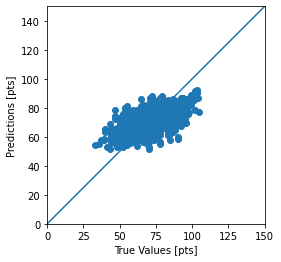

In [18]:
#@title Error Scatter plot
test_predictions = model.predict(test_features)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pts]')
plt.ylabel('Predictions [pts]')
lims = [0, 150]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

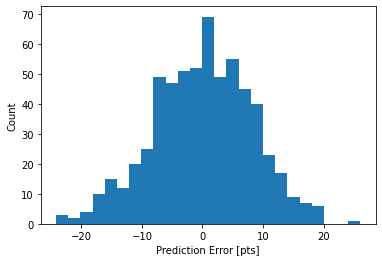

In [19]:
#@title Error Histogram
error = np.mean(test_predictions - test_labels,axis=1)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pts]')
_ = plt.ylabel('Count')

In [20]:
#@title Prediction Winner Accuracy
import random
num_predict =  500#@param {type: "integer"}
num_trials = 10 #@param {type: "integer"}

num_correct = 0

for i in tqdm(range(num_trials)):
  prediction_feature = test_features.sample(n=num_predict)
  actuals = test_labels.loc[prediction_feature.index]
  predictions = model.predict(x=prediction_feature)

  for j in range(predictions.shape[0]):
    prediction = predictions[j]
    actual = actuals.iloc[j].to_numpy()
    prediction_winner = "Team 1" if prediction[0] > prediction[1] else "Team 2"
    actual_winner = "Team 1" if actual[0] > actual[1] else "Team 2"
    if prediction_winner == actual_winner:
      num_correct+=1
    if num_trials-1 <= i and num_predict-1 <= j:
      print('---AVG Game Stats---')
      display(pd.DataFrame(prediction_feature.iloc[j]).T) 
      print(f'\nPredicted pts: [{strformat.format(prediction[0])} - {strformat.format(prediction[1])}]')
      print(f"{prediction_winner} wins")
      print(f'\nActual pts: [{int(actual[0])} - {int(actual[1])}]')
      print(f"{actual_winner} wins")
  

print('\n---Model Winner Accuracy---')
print(f'\nNumber of Trials: {num_trials}')
print(f'Predictions: {num_predict}')

total_preditcions = (num_predict*num_trials)
print(f'Correct Predictions: {num_correct}')
print(f'Total Predictions: {total_preditcions}')
accuracy = (num_correct/total_preditcions) * 100
home_team_winner_accuracy = (game_data[(game_data.t1_pts > game_data.t2_pts) & (game_data['Home']==1)].shape[0] / game_data[(game_data['Home']==1)].shape[0]) * 100

print(f'\nHome Team Winner Accuracy: {strformat.format(home_team_winner_accuracy)}%')
print(f'Model Winner Accuracy: {strformat.format(accuracy)}%')


  0%|          | 0/10 [00:00<?, ?it/s]

---AVG Game Stats---


,Away_avg_left,Away_avg_right,Away_left,Away_right,Home_avg_left,Home_avg_right,Home_left,Home_right,Neutral_avg_left,Neutral_avg_right,Neutral_left,Neutral_right,Semi-Away_avg_left,Semi-Away_avg_right,Semi-Away_left,Semi-Away_right,Semi-Home_avg_left,Semi-Home_avg_right,Semi-Home_left,Semi-Home_right,t1_3fga_avg_left,t1_3fga_avg_right,t1_3fgm_avg_left,t1_3fgm_avg_right,t1_ast_avg_left,t1_ast_avg_right,t1_blk_avg_left,t1_blk_avg_right,t1_dreb_avg_left,t1_dreb_avg_right,t1_fga_avg_left,t1_fga_avg_right,t1_fgm_avg_left,t1_fgm_avg_right,t1_fta_avg_left,t1_fta_avg_right,t1_ftm_avg_left,t1_ftm_avg_right,t1_oreb_avg_left,t1_oreb_avg_right,t1_pf_avg_left,t1_pf_avg_right,t1_pts_avg_left,t1_pts_avg_right,t1_rank_avg_left,t1_rank_avg_right,t1_rank_left,t1_rank_right,t1_stl_avg_left,t1_stl_avg_right,t1_to_avg_left,t1_to_avg_right,t2_3fga_avg_left,t2_3fga_avg_right,t2_3fgm_avg_left,t2_3fgm_avg_right,t2_ast_avg_left,t2_ast_avg_right,t2_blk_avg_left,t2_blk_avg_right,t2_dreb_avg_left,t2_dreb_avg_right,t2_fga_avg_left,t2_fga_avg_right,t2_fgm_avg_left,t2_fgm_avg_right,t2_fta_avg_left,t2_fta_avg_right,t2_ftm_avg_left,t2_ftm_avg_right,t2_oreb_avg_left,t2_oreb_avg_right,t2_pf_avg_left,t2_pf_avg_right,t2_pts_avg_left,t2_pts_avg_right,t2_rank_avg_left,t2_rank_avg_right,t2_rank_left,t2_rank_right,t2_stl_avg_left,t2_stl_avg_right,t2_to_avg_left,t2_to_avg_right
2130,0.4,0.2,0.0,1.0,0.6,0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.2,24.0,8.4,9.0,13.4,16.0,5.2,3.8,24.8,25.6,33.8,39.8,17.2,19.2,18.4,14.0,12.6,12.0,11.6,13.8,17.6,15.0,72.2,77.4,273.8,124.8,277.0,133.0,5.0,8.6,13.6,13.8,18.6,21.8,5.0,6.0,11.2,13.0,2.8,2.0,24.6,22.2,40.0,40.2,21.0,20.4,19.0,16.4,13.6,12.0,11.2,12.0,19.2,15.2,70.6,70.8,257.0,234.2,133.0,277.0,7.2,8.0,12.4,12.8



Predicted pts: [72.28 - 76.47]
Team 2 wins

Actual pts: [79 - 64]
Team 1 wins

---Model Winner Accuracy---

Number of Trials: 10
Predictions: 500
Correct Predictions: 3709
Total Predictions: 5000

Home Team Winner Accuracy: 74.61%
Model Winner Accuracy: 74.18%


#Interactive Model

In [48]:
#@title Game Parameters {display-mode: "form" }

#@markdown Team 1
team_1_name = 'Auburn' #@param {type:"string"}
team_1_year = 2022 #@param {type:"integer"}
team_1_rank =  6#@param {type:"integer"}
team_1_location = 'Home' #@param ["Home", "Away", "Neutral","Semi-Home","Semi-Away"]

#@markdown Team 2
team_2_name = 'Alabama' #@param {type:"string"}
team_2_year = 2022 #@param {type:"integer"}
team_2_rank =  4#@param {type:"integer"}
team_2_location = 'Away' #@param ["Home", "Away", "Neutral","Semi-Home","Semi-Away"]

def predictGame(teams):
  team_1_name = teams[0]['name']
  team_1_year = teams[0]['year']
  team_1_rank = teams[0]['rank']
  team_1_location = teams[0]['location']

  team_2_name = teams[1]['name']
  team_2_year = teams[1]['year']
  team_2_rank = teams[1]['rank']
  team_2_location = teams[1]['location']

  team_1_entry = f'{team_1_name}_{team_1_year}'
  team_2_entry = f'{team_2_name}_{team_2_year}'

  custom_output = game_data.copy()

  custom_output = custom_output.reindex(sorted(custom_output.columns), axis=1)

  team_1_features = custom_output[custom_output.t1_name == team_1_entry].iloc[-prev_games_to_avg:]
  team_1_feature_avg = pd.DataFrame(team_1_features.drop(['date','t1_name'],axis=1).agg('mean')).T
  team_1_feature_avg = team_1_feature_avg.rename(lambda x: x+'_avg', axis='columns')

  team_2_features = custom_output[custom_output.t1_name == team_2_entry].iloc[-prev_games_to_avg:]
  team_2_feature_avg = pd.DataFrame(team_2_features.drop(['date','t1_name'],axis=1).agg('mean')).T
  team_2_feature_avg = team_2_feature_avg.rename(lambda x: x+'_avg', axis='columns')


  team_1_feature_avg['t1_rank'] = team_1_rank
  team_1_feature_avg['t2_rank'] = team_2_rank
  team_2_feature_avg['t1_rank'] = team_2_rank
  team_2_feature_avg['t2_rank'] = team_1_rank


  team_1_feature_avg['Home'] = 1 if team_1_location == 'Home' else 0
  team_1_feature_avg['Away'] = 1 if team_1_location == 'Away' else 0
  team_1_feature_avg['Neutral'] = 1 if team_1_location == 'Neutral' else 0

  team_1_feature_avg['Semi-Home'] = 1 if team_1_location == 'Semi-Home' else 0
  team_1_feature_avg['Semi-Away'] = 1 if team_1_location == 'Semi-Away' else 0



  team_2_feature_avg['Home'] = 1 if team_2_location == 'Home' else 0
  team_2_feature_avg['Away'] = 1 if team_2_location == 'Away' else 0
  team_2_feature_avg['Neutral'] = 1 if team_2_location == 'Neutral' else 0


  team_2_feature_avg['Semi-Home'] = 1 if team_2_location == 'Semi-Away' else 0
  team_2_feature_avg['Semi-Away'] = 1 if team_2_location == 'Semi-Away' else 0

  features = team_1_feature_avg.merge(team_2_feature_avg, suffixes=('_left', '_right'),left_index=True,right_index=True)
  features = features.reindex(sorted(features.columns), axis=1)
  pts = model.predict(features).flatten()
  winner = team_1_name if pts[0] > pts[1] else team_2_name
  return  {'Team 1 Name': team_1_name,'Team 1 Year': team_1_year,'Team 1 Rank': team_1_rank,'Team 1 Location': team_1_location,'Team 1 Points': pts[0],'Team 2 Name': team_2_name,'Team 2 Year': team_2_year,'Team 2 Rank': team_2_rank,'Team 2 Location': team_2_location,'Team 2 Points': pts[1],'Winner': winner,'Spread': pts[0] - pts[1] if pts[1] > pts[0] else pts[1] - pts[0]}

def predictGames(games):
  predictions = []
  for game in games:
    teams = game['teams']

    team_1_name = teams[0]['name']
    team_1_year = teams[0]['year']
    team_1_rank = teams[0]['rank']
    team_1_location = teams[0]['location']

    team_2_name = teams[1]['name']
    team_2_year = teams[1]['year']
    team_2_rank = teams[1]['rank']
    team_2_location = teams[1]['location']
    try:
      predicted_data = predictGame(teams)
      if 'kp' in game:
        prediction_kp = game['kp']
        predicted_data["Kenpom Winner"] = prediction_kp["winner"]
        predicted_data["Kenpom Team 1 Score"] = prediction_kp["score"][0]
        predicted_data["Kenpom Team 2 Score"] = prediction_kp["score"][1]
        predicted_data["Kenpom Spread"] = prediction_kp["spread"]
        predicted_data["Spread Bet"] = "Over" if prediction_kp["spread"] > predicted_data["Spread"] else "Under"
      predictions.append(predicted_data)
    except Exception  as e:
      print(f"Cannot predict game for {team_1_name} vs {team_2_name} ERROR: {str(e)}")
      continue
  return pd.DataFrame(predictions)   


df = predictGames([{'teams':[{'name':team_1_name,'year':team_1_year,'rank':team_1_rank,'location':team_1_location},{'name':team_2_name,'year':team_2_year,'rank':team_2_rank,'location':team_2_location}]}])
display(df)


,Team 1 Name,Team 1 Year,Team 1 Rank,Team 1 Location,Team 1 Points,Team 2 Name,Team 2 Year,Team 2 Rank,Team 2 Location,Team 2 Points,Winner,Spread
0,Auburn,2022,6,Home,80.140549,Alabama,2022,4,Away,73.125984,Auburn,-7.014565


In [49]:
#@title Predict Games on day
date = '2022-01-22' #@param {type: "string"}
games_url = f'{URL}/fanmatch.php?d={date}&s=Time'
driver = init()
login(driver)
print(f'Retrieving games from: {games_url}')
soup = goToURL(driver,games_url)

games = []
rows = [row for row in soup.find('tbody').find_all('tr') if len(row.contents) >=4]
for row in tqdm(rows):
  team_names = row.find_all(href=re.compile('team.php'))
  ranks = row.find_all('span',{'class' : ['seed','seed-gray']})
  ranks = row.find_all('span',{'class' : ['seed','seed-gray']})

  kp_predicted = row.find_all('td')[1].text
  ken_pom_prediction_winner =  re.search(r"\D+",kp_predicted)[0]
  ken_pom_prediction_score =  [int(score) for score in re.findall(r"\d+",kp_predicted)[0:2]]
  ken_pom_prediction_spread = ken_pom_prediction_score[0] - ken_pom_prediction_score[1] if ken_pom_prediction_score[1] > ken_pom_prediction_score[0] else ken_pom_prediction_score[1] - ken_pom_prediction_score[0]
  location = row.find_all('td',style='text-align:left;')
  if not location:
    location = row.find_all('td',class_='bold-bottom-left')

  
  if len(team_names) >= 2:
    teams = [{},{}]    
    teams[0]['name'] = team_names[0].text
    teams[1]['name'] = team_names[1].text

    teams[0]['rank'] = int(ranks[0].text)
    teams[1]['rank'] = int(ranks[1].text)

    teams[0]['year'] = 2022
    teams[1]['year'] = 2022

    teams[0]['location'] = 'Neutral'
    teams[1]['location'] = 'Neutral'

    location = location[-1].find(text=True,recursive=False).lower().strip()
    for i in range(len(team_names)):
      try:
        team_link = f"{URL}/{team_names[i]['href']}"
        team_page = goToURL(driver,team_link)
        arena_name = team_page.find('div',{'id':'title-container'}).find_all(text=True, recursive=False)[1].replace('\n','').split('·')[1].lower().strip()
        if arena_name == location:
          teams[i]['location'] = 'Home'
          teams[0 if i == 1 else 1]['location'] = 'Away'
          break
      except Exception  as e:
        print(f"Cannot determine location for {teams[0]['name']} vs {teams[1]['name']} ERROR: {str(e)}")
        pass
    
    games.append({'teams':teams,'kp': {'winner':ken_pom_prediction_winner,'score': ken_pom_prediction_score, "spread": ken_pom_prediction_spread}})
setPandasDisplayLimit(None)
display(predictGames(games))
setPandasDisplayLimit(10)

Logging in....
Logged In!
Retrieving games from: https://kenpom.com/fanmatch.php?d=2022-01-22&s=Time


  0%|          | 0/137 [00:00<?, ?it/s]

Cannot predict game for Grambling St. vs Mississippi Valley St. ERROR: in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "normalization" (type Normalization).
    
    Dimensions must be equal

,Team 1 Name,Team 1 Year,Team 1 Rank,Team 1 Location,Team 1 Points,Team 2 Name,Team 2 Year,Team 2 Rank,Team 2 Location,Team 2 Points,Winner,Spread,Kenpom Winner,Kenpom Team 1 Score,Kenpom Team 2 Score,Kenpom Spread,Spread Bet
0,Seton Hall,2022,28,Neutral,78.859894,St. John's,2022,94,Neutral,74.348747,Seton Hall,-4.511147,Seton Hall,81,77,-4,Over
1,Texas Tech,2022,13,Home,73.885506,West Virginia,2022,48,Away,62.541149,Texas Tech,-11.344357,Texas Tech,67,58,-9,Over
2,Minnesota,2022,89,Home,69.682549,Rutgers,2022,93,Away,67.300697,Minnesota,-2.381851,Minnesota,65,62,-3,Under
3,Boston College,2022,142,Home,63.134705,Virginia Tech,2022,31,Away,66.837776,Virginia Tech,-3.703072,Virginia Tech,68,62,-6,Under
4,Duke,2022,11,Home,79.540398,Syracuse,2022,74,Away,70.210220,Duke,-9.330177,Duke,85,72,-13,Under
5,Hofstra,2022,120,Away,70.993599,Northeastern,2022,231,Home,68.839363,Hofstra,-2.154236,Hofstra,72,70,-2,Over
6,Villanova,2022,5,Away,75.424805,Georgetown,2022,161,Home,63.888798,Villanova,-11.536007,Villanova,77,63,-14,Under
7,UMBC,2022,262,Neutral,74.131172,Maine,2022,351,Neutral,68.809776,UMBC,-5.321396,UMBC,71,64,-7,Under
8,Northern Kentucky,2022,244,Away,70.039078,IUPUI,2022,358,Home,62.515930,Northern Kentucky,-7.523148,Northern Kentucky,66,55,-11,Under
9,George Washington,2022,280,Away,61.343807,Rhode Island,2022,86,Home,76.976799,Rhode Island,-15.632992,Rhode Island,74,58,-16,Under
